In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import random
from threading import Thread, Lock
import time

In [21]:
# define a base agent class
class Agent:
  def __init__(self, name, expertise):
    self.name = name
    self.expertise = expertise
    self.knowledge = {} # for personal data
    self.messages = [] # inbox for messages from other agents
    self.lock = Lock()

  def receive_message(self, sender, message):
    with self.lock:
      self.messages.append((sender, message))
      print(f"[{time.strftime('%H:%M:%S')}] {self.name} ← received from {sender.name}")

  def process_messages(self):
    with self.lock:
      while self.messages:
        sender, message = self.messages.pop(0)
        self.act_on_message(sender, message)


  def act_on_message(self, sender, message):
    pass

  def send_message(self, recipient, message):
    recipient.receive_message(self, message)

  def run(self):
    while True:
      self.process_messages()
      time.sleep(0.4)

In [37]:
# subclass for patient instake agent
class IntakeAgent(Agent):
  def act_on_message(self, sender, message):
    if message['type'] == 'patient_data_request':
      patient_name = message.get('name', 'john Doe')
      patient_symptoms = message.get('symptoms', ['fever', 'cough'])
      reply = {
          'type' : 'patient_data',
          'patient_name' : patient_name,
          'patient_symptoms' : patient_symptoms
      }
      self.send_message(sender, reply)
      print(f"[{time.strftime('%H:%M:%S')}] {self.name} sent patient data to {sender.name}")

# subclass for dignosis agent
class DiagnosisAgent(Agent):

  def __init__(self, name, expertise):
    super().__init__(name, expertise)
    self.coordinator = None


  def act_on_message(self, sender, message):
    try:
      if message.get('type') == 'patient_data':
        patient_name = message['patient_name']
        patient_symptoms = message['patient_symptoms']
        diagnosis = 'flu' if 'fever' in patient_symptoms else 'cold' if 'cough' in patient_symptoms else 'unknown'
        reply = {'type' : 'diagnosis', 'patient_name' : patient_name, 'diagnosis' : diagnosis}
        self.send_message(self.coordinator, reply)
        print(f"{self.name} sent diagnosis to {self.coordinator.name}")
    except Exception as e:
      print(f"Error in act_on_message: {e}")

## subclass for treatment agent
class TreatmentAgent(Agent):
  def __init__(self, name, expertise):
    super().__init__(name, expertise)
    self.coordinator = None

  def act_on_message(self, sender, message):
    if message.get('type') == 'diagnosis':
      patient_name = message['patient_name']
      diagnosis = message['diagnosis']
      treatment = 'rest' if diagnosis == 'flu' else 'medication' if diagnosis == 'cold' else 'unknown'
      reply = {'type' : 'treatment', 'patient_name' : patient_name, 'treatment' : treatment}
      self.send_message(self.coordinator, reply)
      print(f"{self.name} recommends treatment for {patient_name}: {treatment}")
      print(f"[{time.strftime('%H:%M:%S')}] {self.name} sent treatment to {patient_name}") # Corrected print statement

##subclass for coordinator agent
class CoordinatorAgent(Agent):
  def __init__(self, name, agents):
    super().__init__(name, 'coordination')
    self.agents = agents

  def start_workflow(self):
    intake_agent = next(a for a in self.agents if isinstance(a, IntakeAgent))
    if not intake_agent:
      print("Intake agent not found")
      return
    request = {
            'type': 'patient_data_request',
            'name': 'Neha',
            'symptoms': ['fever', 'cough', 'fatigue']
        }

    self.send_message(intake_agent, request)
    print(f"{self.name} started workflow")

  def act_on_message(self, sender, message):
    if message.get('type') == 'patient_data':
      diagnosis_agent = next(a for a in self.agents if isinstance(a, DiagnosisAgent) )
      self.send_message(diagnosis_agent, message)
    elif message.get('type') == 'diagnosis':
      treatment_agent = next(a for a in self.agents if isinstance(a, TreatmentAgent))
      self.send_message(treatment_agent, message)
    elif message.get('type') == 'treatment':
      print(f"[{time.strftime('%H:%M:%S')}] {self.name} FINISHED → Treatment: {message.get('treatment')} for {message.get('patient_name')}")
      print(f"{self.name} received treatment: {message['treatment']}")

In [38]:
# set up multiple agent system

agents = [
    IntakeAgent('intake_agent', 'patient_intake'),
    DiagnosisAgent('diagnosis_agent', 'diagnosis'),
    TreatmentAgent('treatment_agent', 'treatment'),
]


coordinator = CoordinatorAgent('coordinator', agents)

for agent in agents:
  if hasattr(agent, 'coordinator'):
    agent.coordinator = coordinator

threads = []

# runs agent for concurrency
for agent in agents + [coordinator]:
  t = Thread(target = agent.run, daemon = True)
  t.start()
  threads.append(t)

# start the workflow
coordinator.start_workflow()

time.sleep(10)

[08:23:38] intake_agent ← received from coordinator
coordinator started workflow
[08:23:38] coordinator ← received from intake_agent
[08:23:38] intake_agent sent patient data to coordinator
[08:23:38] diagnosis_agent ← received from coordinator
[08:23:39] coordinator ← received from diagnosis_agent
diagnosis_agent sent diagnosis to coordinator
[08:23:39] treatment_agent ← received from coordinator
[08:23:39] coordinator ← received from treatment_agent
treatment_agent recommends treatment for Neha: rest
[08:23:39] treatment_agent sent treatment to Neha
[08:23:39] coordinator FINISHED → Treatment: rest for Neha
coordinator received treatment: rest


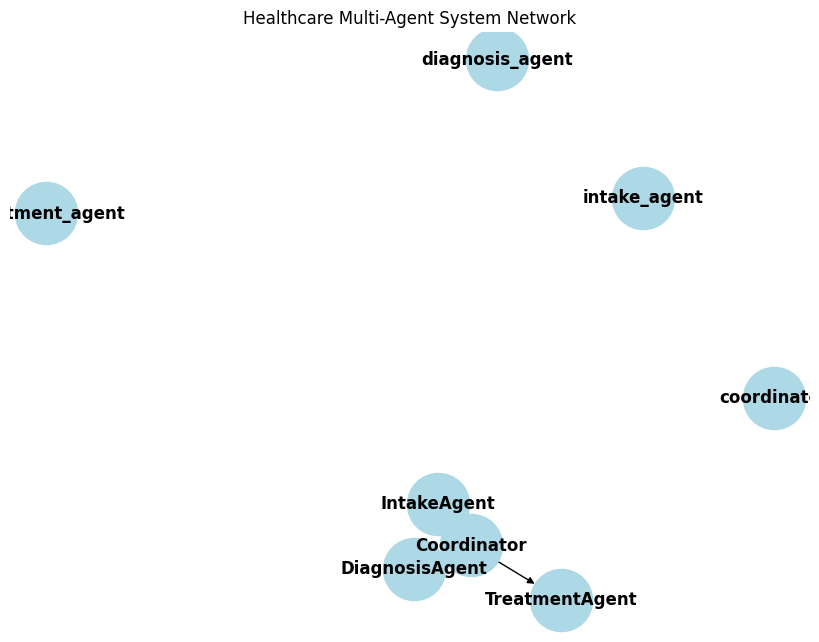

In [39]:

G = nx.DiGraph()
for agent in agents + [coordinator]:
    G.add_node(agent.name)

G.add_edge("Coordinator", "IntakeAgent")
G.add_edge("IntakeAgent", "Coordinator")
G.add_edge("Coordinator", "DiagnosisAgent")
G.add_edge("DiagnosisAgent", "Coordinator")
G.add_edge("Coordinator", "TreatmentAgent")

plt.figure(figsize=(8, 6))
nx.draw(G, with_labels=True, node_color='lightblue', font_weight='bold', node_size=2000)
plt.title("Healthcare Multi-Agent System Network")
plt.show()